In [1]:
import os
import re
import sys
import tensorflow as tf
import tensorflow.python.platform
from tensorflow.python.platform import gfile
import numpy as np

# Image related imports
import av # TODO: Remove this after porting to PIL
from PIL import Image
# from resizeimage import resizeimage
from skimage.feature import hog
from skimage import data, color
from images2gif import writeGif

import matplotlib.pyplot as plt
import pickle

#import seaborn as sns; sns.set()
%matplotlib inline

In [2]:
path_to_video = 'test.mp4'
data_dir = '../data'
images_dir = os.path.join(data_dir, 'frames_tmp_test/')
model_dir = '../imagenet/classify_image_graph_def.pb'
results_dir = '../results/'
cnn_diff_dir = os.path.join(results_dir, 'cnn_diff_tmp')
pixel_diff_dir = os.path.join(results_dir, 'pixel_diff_tmp')
out_dir = os.path.join(results_dir, 'combined_frames_tmp')
path_to_gif = '../gif'

In [3]:
def frame_extractor(path_to_video, path_to_frames):
    container = av.open(path_to_video)
    video = next(s for s in container.streams if s.type == b'video')
    for packet in container.demux(video):
        for frame in packet.decode():
            frame.to_image().save(path_to_frames + '/frame-%06d.jpg' % frame.index)

In [4]:
class FeatureProcessor:
    def __init__(self, model_path, path_to_frames, sampling_rate=10, cnn_threshold=0.8, pixel_threshold=0.8):
        self.model_path = model_path
        self.images_path = sorted([path_to_frames + f for f in os.listdir(path_to_frames) if re.search('jpg|JPG', f)])
        self.sampling_rate = sampling_rate
        self.cnn_threshold = cnn_threshold
        self.pixel_threshold = pixel_threshold 
        
    def create_graph(self):
        with gfile.FastGFile(self.model_path, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            _ = tf.import_graph_def(graph_def, name='')
    
    def get_layer_list(self):
        self.create_graph()
        with tf.Session() as sess:
            operation_list = sess.graph.get_operations()
            for op in operation_list:
                print op.name
                print op.values().get_shape()

    # TODO: Experiment with other layers.            
    def extract_features(self, layer_name='pool_3:0', nb_features=2048):
        features = np.zeros((len(self.images_path), nb_features))
        labels = []
        self.create_graph()
        with tf.Session() as sess:
            next_to_last_tensor = sess.graph.get_tensor_by_name(layer_name)
            for index, image in enumerate(self.images_path):
                if (index % 100 == 0 and index > 0):
                    print('Processing %s...' % (image))
                if not gfile.Exists(image):
                    tf.logging.fatal('File does not exist %s', image)
                    continue
                image_data = gfile.FastGFile(image, 'rb').read()
                predictions = sess.run(next_to_last_tensor, {'DecodeJpeg/contents:0': image_data})
                features[index, :] = np.squeeze(predictions)
        return features
    
    def compute_cnn_change_points(self, distances):
        change_points = np.where((distances/max(distances)) > self.cnn_threshold)
        return change_points
    
    def compute_pixel_change_points(self, distances):
        change_points = np.where((distances/max(distances)) > self.pixel_threshold)
        return change_points
    
    @staticmethod
    def get_feature_differences(features):
        features_1 = features[:-1, :]
        features_2 = features[1:, :]
        saliency_matrix = features_2 - features_1

        differences = []
        for vector in saliency_matrix:
            differences.append(np.linalg.norm(vector))
        differences = np.asarray(differences)
        return differences, saliency_matrix

    def get_pixel_differences(self):
        prev_feature = np.array(Image.open(self.images_path[0])).flatten()
        nb_features = len(prev_feature.flatten())
        distances = []
        for index, next_path in enumerate(self.images_path[1:]):
                if (index % 100 == 0 and index > 0):
                    print('Processing Distance for %s...' % (next_path))
                next_feature = np.array(Image.open(next_path)).flatten()
                distances.append(np.linalg.norm(next_feature - prev_feature))
                prev_feature = next_feature
        return distances
    

In [5]:
class PlotterOut:
    
    @staticmethod
    def save_difference_plots(differences, path, color):
        # 5 = 120 pixels
        differences = differences / max(differences)
        plt.rcParams['figure.figsize'] = (11.25, 3.75) 
        plt.figure()
        num_frames = len(differences)
        for i in range(num_frames):
            plot_file = os.path.join(path, '%06d.png' % i)
            plt.plot(differences[:i+1], color=color)
            plt.xlim([0, num_frames])
            plt.ylim([0, 1])
            plt.savefig(plot_file)
            
    @staticmethod
    def combine_images():
        # plt.rcParams['figure.figsize'] = (10, 5)
        image_paths = os.listdir(images_dir)
        num_images = len(image_paths)
        im = np.asarray(Image.open(os.path.join(images_dir, image_paths[0])))
        image_size = im.shape
        target_size = (image_size[0]/2,image_size[1]/2)
        for i in range(num_images - 1):
            if i % 500 == 0:
                print('Now processing', i, 'out of', num_images)
            im_file = os.path.join(images_dir, image_paths[i])
            cnn_diff_file = os.path.join(cnn_diff_dir, '%06d.png' % i)
            pixel_diff_file = os.path.join(pixel_diff_dir, '%06d.png' % i)
            out_file = os.path.join(out_dir, '%06d.png' % i)
            cnn_diff_im = np.asarray(Image.open(cnn_diff_file))
            pixel_diff_im = np.asarray(Image.open(pixel_diff_file))
            diff_im = np.vstack([cnn_diff_im, pixel_diff_im])
            diff_im = diff_im[:,:,0:3]
            im = Image.open(im_file)
            im = im.resize((diff_im.shape[1],diff_im.shape[0]),Image.ANTIALIAS)
            im = np.asarray(im)
            combined = np.hstack([im, diff_im])
            combined_image = Image.fromarray(combined)
            #combined_image.show()
            combined_image.save(os.path.join(out_dir, '%06d.png' % i), 'PNG')    
    
    @staticmethod
    def get_smoothed_list(list_to_smooth, window_size = 10):
        num_elements = len(list_to_smooth)
        smoothed_list = []
        cur_sum = sum(list_to_smooth[:window_size])
        smoothed_list.append(cur_sum * 1.0 / window_size)
        for i in xrange(window_size, num_elements):
            cur_sum -= list_to_smooth[i-window_size]
            cur_sum += list_to_smooth[i]
            smoothed_list.append(cur_sum * 1.0 / window_size)
        return smoothed_list
    
    @staticmethod
    def plot_differences(feature_differences, pixel_differences):
        feature_differences = feature_differences / max(feature_differences)
        pixel_differences = pixel_differences / max(pixel_differences)
        plt.plot(feature_differences, label='Feature Differences')
        plt.plot(pixel_differences, label='Pixel Differences')
        
    @staticmethod   
    def generate_gif(change_point_list, path_to_frames, path_to_gif):
        all_images_list = [path_to_frames + f for f in os.listdir(path_to_frames) if re.search('jpg|JPG', f)]
        selected_gif_images = [Image.open(all_images_list[change_points]) for change_points in change_point_list]
        writeGif(path_to_gif, selected_gif_images, duration=0.3, subRectangles=False)

Processing ../data/frames_tmp_test/0100.jpg...
Processing Distance for ../data/frames_tmp_test/0101.jpg...
('Now processing', 0, 'out of', 104)


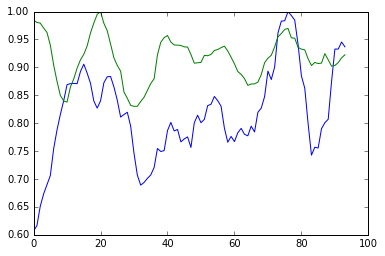

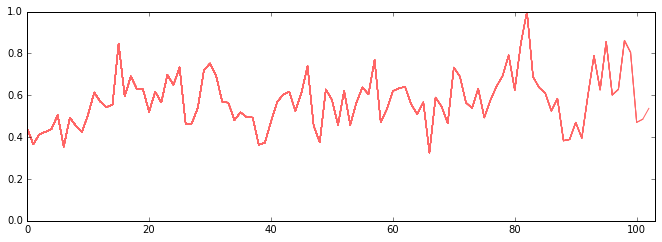

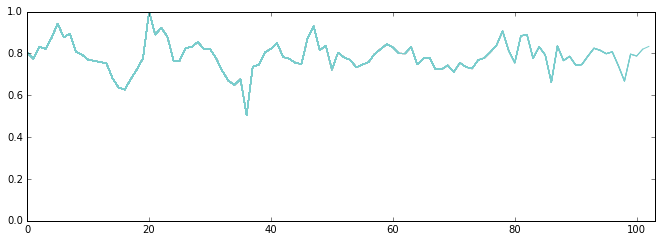

In [6]:
if __name__ == "__main__":
    feature_processor = FeatureProcessor(model_dir, images_dir)
    feature_processor.create_graph()
    features = feature_processor.extract_features()
    cnn_differences, saliency_matrix = feature_processor.get_feature_differences(features)
    pixel_differences = feature_processor.get_pixel_differences()
    cnn_change_points = feature_processor.compute_cnn_change_points(cnn_differences)
    pixel_change_points = feature_processor.compute_pixel_change_points(pixel_differences)
    plotter_out = PlotterOut()
    plotter_out.generate_gif(cnn_change_points[0].tolist(), images_dir, path_to_gif+'/cnn.gif')
    plotter_out.generate_gif(pixel_change_points[0].tolist(), images_dir, path_to_gif+'/pixel.gif')
    plotter_out.plot_differences(plotter_out.get_smoothed_list(cnn_differences), plotter_out.get_smoothed_list(pixel_differences))
    plotter_out.save_difference_plots(cnn_differences, cnn_diff_dir, '#ff6666')
    plotter_out.save_difference_plots(pixel_differences, pixel_diff_dir, '#79cdcd')
    plotter_out.combine_images()